# Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import config
from joblib import dump, load
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import rc
from GMHI import GMHI

# Set constants

In [2]:
# set figure details
figsize = (10, 5)
dpi = 200

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

filename = "performance_per_phenotype-study_combination.svg"

# Load data

In [3]:
X = pd.read_csv(os.path.join(config.CLEAN_DIR, "taxonomic_features.csv"), index_col=[0, 1])
y = pd.read_csv(os.path.join(config.CLEAN_DIR, "is_healthy.csv"), index_col=[0, 1])
phenotype = pd.read_csv(os.path.join(config.CLEAN_DIR, "phenotype.csv"), index_col=[0, 1])
GMHI2_scores_cv = pd.read_csv(os.path.join(config.PREDICTION_DIR, "GMHI2_scores_cv.csv"), index_col=[0, 1])
display(X.head())
display(y.head())
display(GMHI2_scores_cv.head())

k__Archaea  k__Archaea|p__Euryarchaeota  \
Study_ID Sample Accession                                            
GMHI-10  SAMN03283239        0.000000                     0.000000   
         SAMN03283266        0.000000                     0.000000   
         SAMN03283281        0.009764                     0.009764   
         SAMN03283245        0.106067                     0.106067   
         SAMN03283294        0.000000                     0.000000   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria  \
Study_ID Sample Accession                                                   
GMHI-10  SAMN03283239                                            0.000000   
         SAMN03283266                                            0.000000   
         SAMN03283281                                            0.009764   
         SAMN03283245                                            0.106067   
         SAMN03283294                                            0.000000   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales  \
Study_ID Sample Accession                                                                         
GMHI-10  SAMN03283239                                               0.000000                      
         SAMN03283266                                               0.000000                      
         SAMN03283281                                               0.009764                      
         SAMN03283245                                               0.106067                      
         SAMN03283294                                               0.000000                      

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae  \
Study_ID Sample Accession                                                                                                
GMHI-10  SAMN03283239                                               0.000000                                             
         SAMN03283266                                               0.000000                                             
         SAMN03283281                                               0.009764                                             
         SAMN03283245                                               0.106067                                             
         SAMN03283294                                               0.000000                                             

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter  \
Study_ID Sample Accession                                                                                                                      
GMHI-10  SAMN03283239                                               0.000000                                                                   
         SAMN03283266                                               0.000000                                                                   
         SAMN03283281                                               0.009764                                                                   
         SAMN03283245                                               0.072453                                                                   
         SAMN03283294                                               0.000000                                                                   

                           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii  \
Study_ID Sample Accession                                                                                                                                                    
GMHI-10  SAMN03283239                                               0.000000              

PHENOTYPE:Healthy_Nonhealthy
Study_ID Sample Accession                              
GMHI-10  SAMN03283239                              True
         SAMN03283266                              True
         SAMN03283281                              True
         SAMN03283245                              True
         SAMN03283294                              True

GMHI2_cv
Study_ID Sample Accession          
GMHI-10  SAMN03283239      1.876379
         SAMN03283266      0.273884
         SAMN03283281      0.942891
         SAMN03283245      1.152237
         SAMN03283294      2.140906

# Rank order and plot

In [4]:
np.unique(phenotype)

array(['Ankylosing spondylitis', 'Atherosclerotic cardiovascular disease',
       'Behcet’s disease', 'Breast Cancer', 'Colorectal adenoma',
       'Colorectal cancer', "Crohn's Disease", 'End-stage renal disease',
       'Graves’ disease', 'Healthy', 'Hypertension',
       'Impaired glucose tolerance', 'Liver Cirrhosis', 'NAFLD',
       'Pancreatic cancer', 'Rheumatoid arthritis', 'Schizophrenia',
       'Type 2 diabetes', 'Ulcerative colitis'], dtype=object)

In [5]:
info = pd.DataFrame((GMHI2_scores_cv > 0).values, index=GMHI2_scores_cv.index, columns=["predicted"])
info["phenotype"] = phenotype
info["y"] = y

# remove samples with low GMHI2 score magnitudes
cutoff = 1
info = info[(abs(GMHI2_scores_cv) >= cutoff).values]
info

predicted phenotype     y
Study_ID Sample Accession                           
GMHI-10  SAMN03283239           True   Healthy  True
         SAMN03283245           True   Healthy  True
         SAMN03283294           True   Healthy  True
         SAMN03283288           True   Healthy  True
         SAMN03283260           True   Healthy  True
...                              ...       ...   ...
P98      SAMEA6104861           True   Healthy  True
         SAMEA6104856           True   Healthy  True
         SAMEA6104855           True   Healthy  True
         SAMEA6104859          False   Healthy  True
         SAMEA6104853          False   Healthy  True

[4422 rows x 3 columns]

In [6]:
study_scores = []

for p in np.unique(phenotype):
    phenotype_df = info[(info["phenotype"] == p).values]
    phenotype_studies = np.unique(phenotype_df.index.get_level_values(0))
    for s in phenotype_studies:
        curr_df = phenotype_df.loc[s]
        acc = accuracy_score(curr_df["y"], curr_df["predicted"])
        study_scores.append({
            "phenotype" : p,
            "study" : s,
            "acc" : acc
        })

In [7]:
df = pd.DataFrame(sorted(study_scores, key=lambda x : (x["phenotype"], 1 - x["acc"]), ))
df = df.set_index(["phenotype", "study"])
df

acc
phenotype                              study              
Ankylosing spondylitis                 GMHI-V-41  0.880000
Atherosclerotic cardiovascular disease GMHI-2     0.994118
Behcet’s disease                       P15        1.000000
Breast Cancer                          P32        0.966667
Colorectal adenoma                     P48        0.911765
...                                                    ...
Ulcerative colitis                     P56        0.750000
                                       GMHI-28    0.666667
                                       P57        0.642857
                                       GMHI-9     0.321429
                                       P140       0.000000

[92 rows x 1 columns]

In [8]:
# get only phenotypes with multiple studies
idx = df.groupby(level=0).count().sort_values("acc", ascending=False)
idx = idx[(idx > 1).values]
idx

,acc
phenotype,
Healthy,51
Crohn's Disease,7
Colorectal cancer,6
Ulcerative colitis,6
Colorectal adenoma,4
Type 2 diabetes,4
Rheumatoid arthritis,2


In [9]:
df = df.loc[idx.index]
df

acc
phenotype            study              
Healthy              GMHI-28    1.000000
                     GMHI-5     1.000000
                     GMHI-V-35  1.000000
                     GMHI-V-40  1.000000
                     P56        1.000000
...                                  ...
Type 2 diabetes      GMHI-4     0.978022
                     P21        0.958333
                     GMHI-5     0.233333
Rheumatoid arthritis GMHI-17    0.820000
                     P34        0.428571

[80 rows x 1 columns]

In [10]:
# look at unique studies within this subset of phenotypes
unique_studies = np.unique(df.index.get_level_values(1))
unique_studies, unique_studies.shape[0]

(array(['GMHI-10', 'GMHI-11', 'GMHI-13', 'GMHI-14', 'GMHI-15', 'GMHI-17',
        'GMHI-2', 'GMHI-21', 'GMHI-23', 'GMHI-24', 'GMHI-26', 'GMHI-27',
        'GMHI-28', 'GMHI-3', 'GMHI-31', 'GMHI-32', 'GMHI-33', 'GMHI-4',
        'GMHI-5', 'GMHI-9', 'GMHI-V-35', 'GMHI-V-38', 'GMHI-V-40',
        'GMHI-V-41', 'P11', 'P110', 'P121', 'P132', 'P135', 'P140', 'P15',
        'P17', 'P2', 'P21', 'P24', 'P32', 'P34', 'P39', 'P48', 'P53',
        'P56', 'P57', 'P69', 'P74', 'P77', 'P8', 'P80', 'P81', 'P87',
        'P88', 'P89', 'P9', 'P94', 'P95', 'P96', 'P98'], dtype=object),
 56)

In [11]:
# look at phenotypes, number of phenotypes
phenotypes = np.unique(df.index.get_level_values(0))
phenotypes, phenotypes.shape[0]

(array(['Colorectal adenoma', 'Colorectal cancer', "Crohn's Disease",
        'Healthy', 'Rheumatoid arthritis', 'Type 2 diabetes',
        'Ulcerative colitis'], dtype=object),
 7)

In [12]:
cmap = plt.get_cmap('Set1')
colors = cmap(np.linspace(0, 1, phenotypes.shape[0]))
color_dic = dict([(p, colors[i]) for i, p in enumerate(phenotypes)])
color_dic

{'Colorectal adenoma': array([0.89411765, 0.10196078, 0.10980392, 1.        ]),
 'Colorectal cancer': array([0.21568627, 0.49411765, 0.72156863, 1.        ]),
 "Crohn's Disease": array([0.59607843, 0.30588235, 0.63921569, 1.        ]),
 'Healthy': array([1.        , 0.49803922, 0.        , 1.        ]),
 'Rheumatoid arthritis': array([0.65098039, 0.3372549 , 0.15686275, 1.        ]),
 'Type 2 diabetes': array([0.96862745, 0.50588235, 0.74901961, 1.        ]),
 'Ulcerative colitis': array([0.6, 0.6, 0.6, 1. ])}

In [13]:
colors = [color_dic[p] for p in df.index.get_level_values(0)]
colors[:10]

[array([1.        , 0.49803922, 0.        , 1.        ]),
 array([1.        , 0.49803922, 0.        , 1.        ]),
 array([1.        , 0.49803922, 0.        , 1.        ]),
 array([1.        , 0.49803922, 0.        , 1.        ]),
 array([1.        , 0.49803922, 0.        , 1.        ]),
 array([1.        , 0.49803922, 0.        , 1.        ]),
 array([1.        , 0.49803922, 0.        , 1.        ]),
 array([1.        , 0.49803922, 0.        , 1.        ]),
 array([1.        , 0.49803922, 0.        , 1.        ]),
 array([1.        , 0.49803922, 0.        , 1.        ])]

In [14]:
tick_labels = [f"{p} ({df.loc[p].shape[0]} studies)" for p in idx.index]
ticks = idx["acc"].values

prefix_sum = [0]
for t in ticks:
    prefix_sum.append(prefix_sum[-1] + t)
    
ticks = prefix_sum[:-1] + ticks // 2
tick_labels, ticks

(['Healthy (51 studies)',
  "Crohn's Disease (7 studies)",
  'Colorectal cancer (6 studies)',
  'Ulcerative colitis (6 studies)',
  'Colorectal adenoma (4 studies)',
  'Type 2 diabetes (4 studies)',
  'Rheumatoid arthritis (2 studies)'],
 array([25, 54, 61, 67, 72, 76, 79]))

In [15]:
# get means
means = df.groupby(level=0, sort=False).mean()
means

,acc
phenotype,
Healthy,0.708492
Crohn's Disease,0.807633
Colorectal cancer,0.772280
Ulcerative colitis,0.563492
Colorectal adenoma,0.568673
Type 2 diabetes,0.792422
Rheumatoid arthritis,0.624286


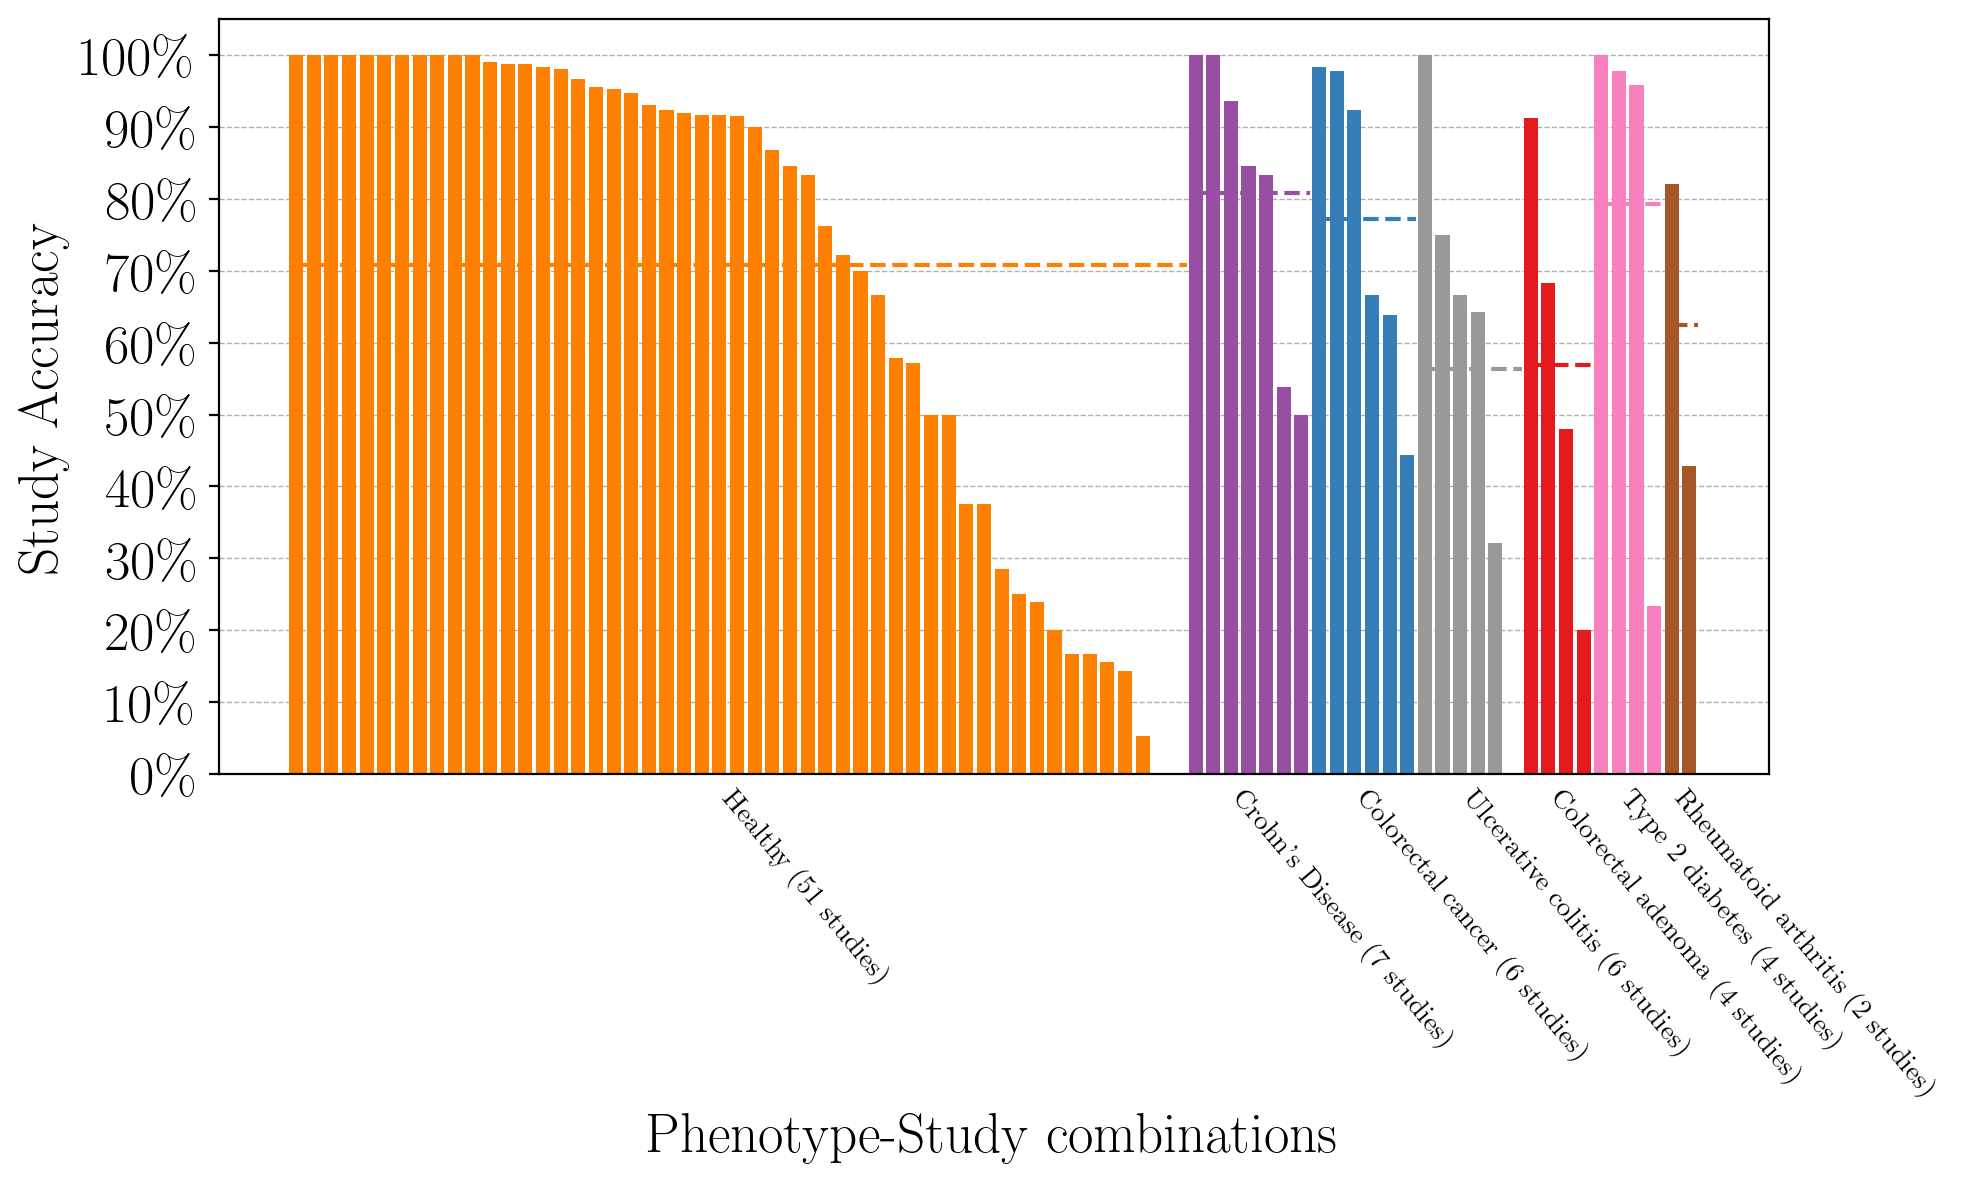

In [16]:
fig = plt.figure(figsize=figsize, dpi=dpi)
ax = plt.gca()

# get percentages on y axis
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.yticks(np.arange(0, 1.1, 0.1))
ax.tick_params(axis="y", labelsize=20)

# Set phenotype labels
ax.set_xlabel("Phenotype-Study combinations", fontsize=20)
# ax.tick_params(labelbottom=False)
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels, ha="left", rotation_mode='anchor')
ax.tick_params(axis="x", labelrotation=-50, length=0)


# Get griddy    
ax.set_axisbelow(True)
plt.grid(linestyle = '--', axis="y", linewidth = 0.5)

# draw mean lines
for i, (mea, tick) in enumerate(zip(means.values, ticks)):
    xmin = prefix_sum[i]
    xmax = prefix_sum[i + 1] - 0.5
    col = colors[tick]
    plt.plot([xmin, xmax], [mea, mea], "--", c=col)


ax.set_ylabel("Study Accuracy", fontsize=20)
plt.bar(np.arange(0, df.shape[0]), df["acc"].values, color=colors)
plt.savefig(os.path.join(config.FIGURE_DIR, filename), bbox_inches="tight")

In [17]:
set(X.index.get_level_values(0)) - set(df.index.get_level_values(1))

{'GMHI-V-36'}